In [1]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
import pandas as pd
# from pandas_profiling import ProfileReport
import numpy as np
import warnings
import mlflow
from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()

ROOT = os.environ.get('PWD')

warnings.filterwarnings('ignore')






# Data cleaning and feature engineering

In [ ]:
# set global default to be able to see all columns

pd.set_option('display.max_rows', None)

In [13]:
# read from csv

master = pd.read_csv('../data/excellent_master.csv')

In [15]:
master.duplicated()

0          False
1          False
2          False
3          False
4          False
           ...  
1521127    False
1521128    False
1521129    False
1521130    False
1521131    False
Length: 1521132, dtype: bool

In [4]:
len(master)

1521132

In [42]:
list(master.columns.values)

['listing_id',
 'top',
 'year',
 'month',
 'inquiry_count',
 'children`s_room',
 'corridor',
 'dining_room',
 'kitchen',
 'kitchen_living',
 'living_bedroom',
 'living_/_dining_room',
 'living_room',
 'separate_WC',
 'storage_room',
 'washroom',
 'wellness',
 'Blu-ray_player',
 'CDs_DVDs',
 'DVD-player',
 'additional_bed',
 'armchair',
 'awning_',
 'bath_towels',
 'bathtub',
 'beach_chair',
 'bed_linen',
 'bicycles',
 'books',
 'bread_service',
 'bunk_bed',
 'carport',
 'central_heating',
 'chest_of_drawers',
 "child's_bed",
 'children_toilet_seat',
 'cleaning_supplies',
 'coffee_machine',
 'colouring_book_pencils',
 'crockery',
 'desk',
 'dining_table',
 'double_bed',
 'double_wash_basin',
 'drying_rack',
 'egg_cooker',
 'fire_alarm',
 'fireplace',
 'first-aid_kit',
 'flat_iron',
 'fly_screen',
 'food_processor',
 'freezer',
 'games',
 'garage',
 'garden_furniture',
 'garden_shed',
 'hair_dryer',
 'high_chair',
 'hot_water',
 'ironing_board',
 'kettle',
 'laundry_service',
 'lawn',
 '

In [60]:
# drop necessary columns
drop_list = ['Unnamed: 0','Unnamed: 0.1','Unnamed: 0_x','Unnamed: 0_y','arrival_date']

for i in drop_list:
    master.drop([i],axis=1,inplace=True)

KeyError: "['Unnamed: 0'] not found in axis"

In [ ]:
master.nunique()

In [26]:
# select the filter that is appropriate for the data range. 
# NOTE: the range is not automatically reflected in the name of the dataframe--
# but it should be put into the parameters for ML Flow

# by default, the master set has both years, 2019 and 2020, so it needs no filter

# master_filter = master

# to filter only 2019 data
master_filter = master.query('year == 2019').reset_index()

# to filter only 2020 data
# master_filter = master.query('year == 2020')

In [27]:
len(master_filter)

476790

In [ ]:
master_filter.isna().sum()

## the data set has no missing values

In [33]:
# generate the feature mean_price_per_day 

master_filter_price_agg = master_filter.groupby(['listing_id','month']).agg(['mean'])['filled_in_price_per_day'].reset_index()

In [ ]:
master_filter_price_agg.head(2)

In [61]:

master_filter_1 = pd.merge(master_filter_price_agg, master_filter, left_on=['listing_id','month'], right_on=['listing_id','month'], how='right')

In [62]:
master_filter_1.rename(columns={'mean':'mean_price_per_day'},inplace=True)

In [36]:
master_filter_1.nunique()

listing_id                   8388
month                          12
mean_price_per_day           1265
index                      476790
top                             2
                            ...  
living_area                   125
lat                           217
lng                           217
filled_in_price_per_day       503
inquiry_rate                  101
Length: 147, dtype: int64

In [37]:
len(master_filter_1)

476790

In [63]:
list(master_filter_1.columns.values)

['listing_id',
 'month',
 'mean_price_per_day',
 'index',
 'top',
 'year',
 'inquiry_count',
 'children`s_room',
 'corridor',
 'dining_room',
 'kitchen',
 'kitchen_living',
 'living_bedroom',
 'living_/_dining_room',
 'living_room',
 'separate_WC',
 'storage_room',
 'washroom',
 'wellness',
 'Blu-ray_player',
 'CDs_DVDs',
 'DVD-player',
 'additional_bed',
 'armchair',
 'awning_',
 'bath_towels',
 'bathtub',
 'beach_chair',
 'bed_linen',
 'bicycles',
 'books',
 'bread_service',
 'bunk_bed',
 'carport',
 'central_heating',
 'chest_of_drawers',
 "child's_bed",
 'children_toilet_seat',
 'cleaning_supplies',
 'coffee_machine',
 'colouring_book_pencils',
 'crockery',
 'desk',
 'dining_table',
 'double_bed',
 'double_wash_basin',
 'drying_rack',
 'egg_cooker',
 'fire_alarm',
 'fireplace',
 'first-aid_kit',
 'flat_iron',
 'fly_screen',
 'food_processor',
 'freezer',
 'games',
 'garage',
 'garden_furniture',
 'garden_shed',
 'hair_dryer',
 'high_chair',
 'hot_water',
 'ironing_board',
 'kettle'

In [64]:
# drop more things that need not be in the data set

drop_list = ['year',
 'option_holiday_with_your_pet','option_holiday_with_your_horse']

for i in drop_list:
    master_filter_1.drop([i],axis=1,inplace=True)

In [65]:
master_filter_1.drop(['index'],axis=1,inplace=True)

In [ ]:
# save to csv if desired: this is the normed, filtered set with agg price data for the years in question

master_filter_1.to_csv('../data/master_filter_price_agg.csv')

In [ ]:
master_filter_1 = pd.read_csv('../data/master_filter_price_agg.csv')

In [66]:
master_filter_1['property_type'].unique()

array(['holiday_apartment', 'holiday_houses'], dtype=object)

In [67]:
# convert property types into binary: holiday apartment = 0, and holiday_houses = 1
master_filter_1['prop_bin'] = 1


In [68]:
master_filter_1.loc[master_filter_1['property_type'] == 'holiday_apartment', 'prop_bin'] = 0

In [41]:
master_filter_1.head()

,listing_id,month,mean_price_per_day,index,top,year,inquiry_count,children`s_room,corridor,dining_room,...,balcony,bathrooms,bedrooms,max_guests,living_area,lat,lng,filled_in_price_per_day,inquiry_rate,prop_bin
0,c5c0fcff-faf3-5a07-a0d9-fe2857025cd8,1,65.0,2496,0.0,2019,1,0.0,1.0,0.0,...,0.0,1.0,1.0,2.0,60.0,53.626845,7.293929,65.0,0.04,0
1,6ec2303b-5083-50ef-bead-9e3d839f3caa,1,55.0,2497,0.0,2019,1,0.0,0.0,0.0,...,0.0,1.0,2.0,4.0,65.0,53.207069,7.986032,55.0,0.02,1
2,bfeddf97-945f-5cd4-96e4-dcbe170e8410,1,54.0,2498,0.0,2019,1,0.0,0.0,0.0,...,1.0,1.0,0.0,3.0,40.0,53.938466,10.678566,54.0,0.01,0
3,1c883ca8-3a96-56b0-b8e9-1d9f7f4a9180,2,60.0,2499,0.0,2019,1,0.0,0.0,0.0,...,0.0,1.0,1.0,2.0,81.0,51.271444,8.546197,60.0,0.02,0
4,e8224b68-1c9b-5464-8c28-565798996ea5,2,50.0,2500,0.0,2019,1,0.0,0.0,0.0,...,0.0,1.0,1.0,3.0,45.0,49.343352,8.109466,50.0,0.02,0


In [71]:
master_filter_1.drop(['filled_in_price_per_day'],axis=1,inplace=True)

KeyError: "['filled_in_price_per_day'] not found in axis"

In [72]:
master_filter_1.drop(['property_type'],axis=1,inplace=True)

KeyError: "['property_type'] not found in axis"

In [87]:
master_filter_1.drop(['option_technicians'],axis=1,inplace=True)

In [80]:
list(master_filter_1.columns.values)

['listing_id',
 'month',
 'mean_price_per_day',
 'top',
 'inquiry_count',
 'children`s_room',
 'corridor',
 'dining_room',
 'kitchen',
 'kitchen_living',
 'living_bedroom',
 'living_/_dining_room',
 'living_room',
 'separate_WC',
 'storage_room',
 'washroom',
 'wellness',
 'Blu-ray_player',
 'CDs_DVDs',
 'DVD-player',
 'additional_bed',
 'armchair',
 'awning_',
 'bath_towels',
 'bathtub',
 'beach_chair',
 'bed_linen',
 'bicycles',
 'books',
 'bread_service',
 'bunk_bed',
 'carport',
 'central_heating',
 'chest_of_drawers',
 "child's_bed",
 'children_toilet_seat',
 'cleaning_supplies',
 'coffee_machine',
 'colouring_book_pencils',
 'crockery',
 'desk',
 'dining_table',
 'double_bed',
 'double_wash_basin',
 'drying_rack',
 'egg_cooker',
 'fire_alarm',
 'fireplace',
 'first-aid_kit',
 'flat_iron',
 'fly_screen',
 'food_processor',
 'freezer',
 'games',
 'garage',
 'garden_furniture',
 'garden_shed',
 'hair_dryer',
 'high_chair',
 'hot_water',
 'ironing_board',
 'kettle',
 'laundry_service

In [88]:
# trying not to be a dummy by getting dummies
master_dummies = pd.get_dummies(master_filter_1, columns=['holiday_region','title','option_allergic',
 'option_non_smoking_only',
 'option_holiday_with_your_dog',
 'option_close_to_the_beach',
 'option_wheelchair_accessible',
 'option_family_travel',
 'option_close_to_the_water',
 'option_holiday_with_your_baby',
 'option_long_term_holiday',
 'option_fully_accessible',
 'option_close_to_the_ski_lift'])

In [ ]:
list(master_dummies.columns_values)

In [89]:
master_dummies.columns = master_dummies.columns.str.replace("[_]", "")

In [18]:
master_dummies.head(2)

,listingid,month,meanpriceperday,top,inquirycount,childrensroom,corridor,diningroom,kitchen,kitchenliving,...,holidayregionSauerland,holidayregionSchwarzwald,holidayregionSpreewald,holidayregionSylt,holidayregionSchsischeSchweiz,holidayregionThringerWald,titleAnfrage,titleDirektbuchen,titleExterneBuchung,titleVerbindlicheAnfrage
0,c5c0fcff-faf3-5a07-a0d9-fe2857025cd8,1,65.0,0.0,1,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,1,0,0,0
1,6ec2303b-5083-50ef-bead-9e3d839f3caa,1,55.0,0.0,1,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0


# move now to do the train test split and then the model

In [90]:
# create X and Y sets for train test split

X = master_dummies.drop(['listingid','inquirycount'],axis=1)
Y = master_dummies['inquirycount']

In [91]:
# train test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

## Trainining the model and tracking with MLFlow

In [21]:
# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.start_run()
run = mlflow.active_run()

In [22]:
print("Active run_id: {}".format(run.info.run_id))

Active run_id: 59a3c60ee78b4cea81003298dbc46ea8


In [77]:
#training the model
# !pip install --upgrade pip
# !pip install lightgbm

from lightgbm import LGBMRegressor


In [92]:
# set LGBM parameters

clf = LGBMRegressor(
    n_estimators=400,
    learning_rate=0.01,
    colsample_bytree=.8,
    max_depth=10,
    reg_alpha=.1,
    reg_lambda=.1,
    min_split_gain=.01,
    min_child_weight=2,
    silent=-1,
    verbose=-1,
)

clf.fit(
    X_train, y_train, 
    eval_set= [(X_train, y_train), (X_test, y_test)], 
    eval_metric='rmse', verbose=100, early_stopping_rounds=100  #100
)

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 14.1822	training's l2: 201.134	valid_1's rmse: 14.2445	valid_1's l2: 202.906
[200]	training's rmse: 7.84745	training's l2: 61.5824	valid_1's rmse: 7.84809	valid_1's l2: 61.5926
[300]	training's rmse: 5.83941	training's l2: 34.0987	valid_1's rmse: 5.82052	valid_1's l2: 33.8784
[400]	training's rmse: 5.11975	training's l2: 26.2119	valid_1's rmse: 5.11093	valid_1's l2: 26.1216
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 5.11975	training's l2: 26.2119	valid_1's rmse: 5.11093	valid_1's l2: 26.1216


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.01, max_depth=10,
              min_child_weight=2, min_split_gain=0.01, n_estimators=400,
              reg_alpha=0.1, reg_lambda=0.1, silent=-1, verbose=-1)

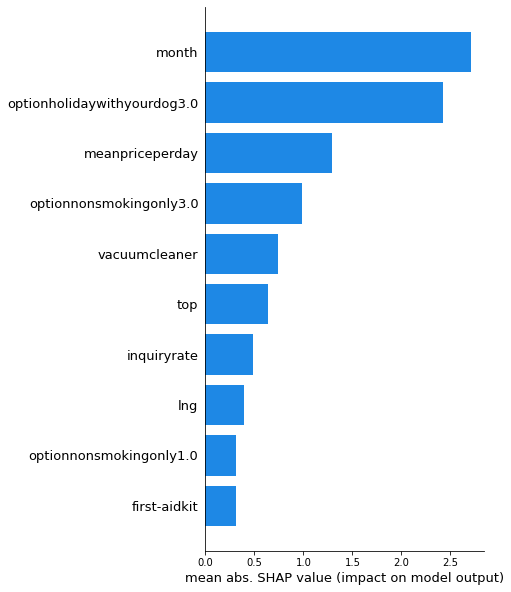

In [93]:
# %%

# !pip install shap

import shap
import matplotlib.pyplot as pl 
shap_values = shap.TreeExplainer(clf.booster_).shap_values(X_train.iloc[:10000,:])
shap_values.shape


# %%
global_importances = np.abs(shap_values).mean(0)[:-1]


# %%
# make a bar chart that shows the global importance of the top 10 features
inds = np.argsort(-global_importances)
f = pl.figure(figsize=(5,10))
y_pos = np.arange(10)
inds2 = np.flip(inds[:10], 0)
pl.barh(y_pos, global_importances[inds2], align='center', color="#1E88E5")
pl.yticks(y_pos, fontsize=13)
pl.gca().set_yticklabels(X_train.columns[inds2])
pl.xlabel('mean abs. SHAP value (impact on model output)', fontsize=13)
pl.gca().xaxis.set_ticks_position('bottom')
pl.gca().yaxis.set_ticks_position('none')
pl.gca().spines['right'].set_visible(False)
pl.gca().spines['top'].set_visible(False)

In [ ]:
params = {
      "model":"LightGBMBoost",
      "year":'2019',
      "train_test_split": 30,
      "normalized data": 'yes',
      "metric": 'rmse'
  }

In [ ]:
mlflow.log_params(params)
mlflow.set_tag("running_from_jupyter", "baseline model 2019")
mlflow.log_metric("train -" + "RMSE", rmse_train)
mlflow.log_metric("test -" + "RMSE", rmse_test)
# mlflow.log_artifact("../models")
# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

In [ ]:
mlflow.get_run(run_id=run.info.run_id)

## Checking the experiments

while the next cell is running you will not be able to run other cells in the notebook

In [ ]:
!mlflow ui